# Handling imbalanced Datasets 

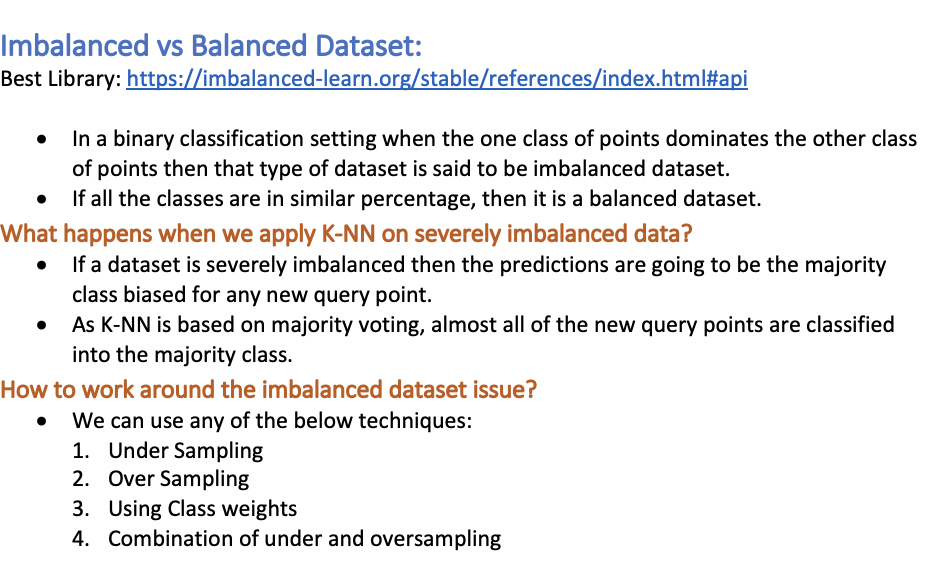

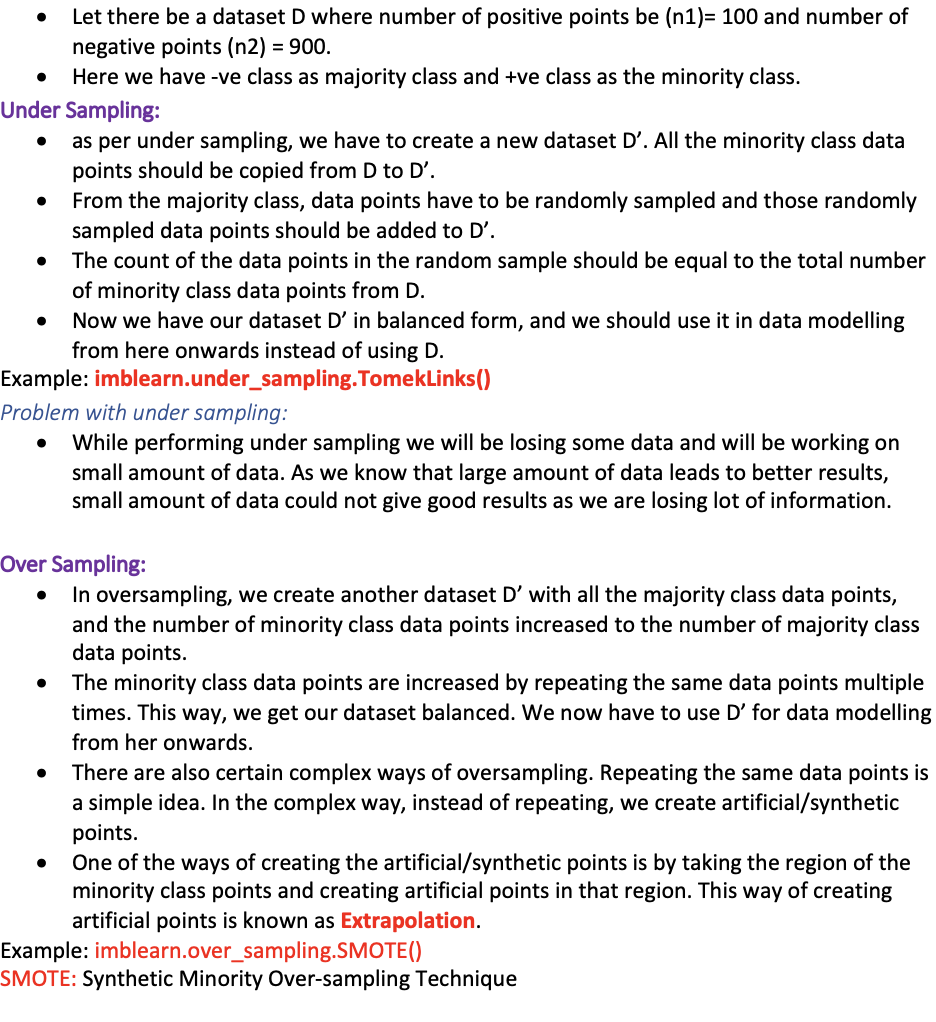

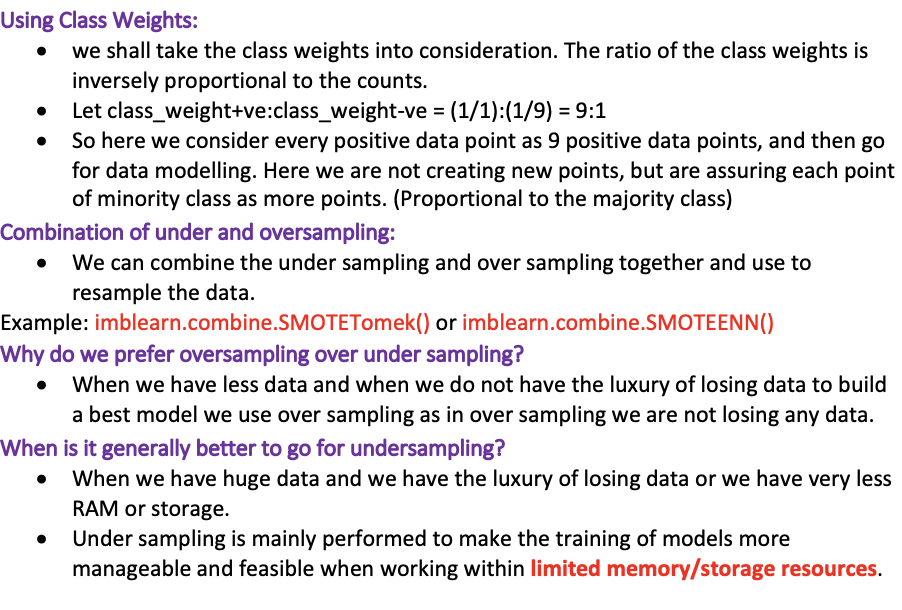

# About dataset

We are using The Porto Seguro's Safe Driver Prediction competitions data , and it is a classic problem of unbalanced classes, since insurance claims can be considered unusual cases when considering all clients. Other classic examples of unbalanced classes are the detection of financial fraud and attacks on computer networks.


# lets Download data from kaggle


In [4]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c porto-seguro-safe-driver-prediction
!unzip /content/porto-seguro-safe-driver-prediction.zip

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 65% 50.0M/76.5M [00:00<00:00, 277MB/s]
100% 76.5M/76.5M [00:00<00:00, 291MB/s]
Archive:  /content/porto-seguro-safe-driver-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


Class 0: 573518
Class 1: 21694
Proportion: 26.44 : 1


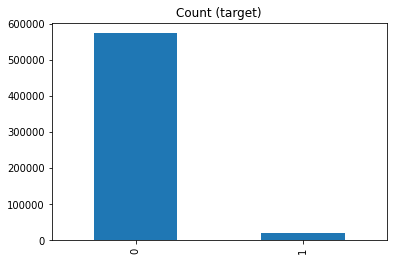

In [5]:
import numpy as np
import pandas as pd

df_train = pd.read_csv('train.csv')

target_count = df_train.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [6]:
df_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


<h2 id="t2" style="margin-bottom: 18px">Selecting the proper performance metric</h2>

One of the major issues when dealing with unbalanced datasets relates to the metrics used to evaluate the model. Using simpler metrics like <code>accuracy_score</code> can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

Let's do this experiment, using simple cross-validation and no feature engineering:

In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Remove 'id' and 'target' columns
labels = df_train.columns[2:]

X = df_train[labels]
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.36%


Now let's run the same code, but using only one feature (which should drastically reduce the accuracy of the classifier):

In [8]:
model = XGBClassifier()
model.fit(X_train[['ps_calc_01']], y_train)
y_pred = model.predict(X_test[['ps_calc_01']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.36%


As we can see, the high accuracy rate was just an illusion. In this way, the choice of the metric used in unbalanced datasets is extremely important. Hence we use the evaluation metric as the Normalized Gini Coefficient, a more robust metric for imbalanced datasets, that ranges from approximately 0 for random guessing, to approximately 0.5 for a perfect score.

## lets see the confusion matrix

In confusion matrix the higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

Confusion matrix:
 [[114709      0]
 [  4334      0]]


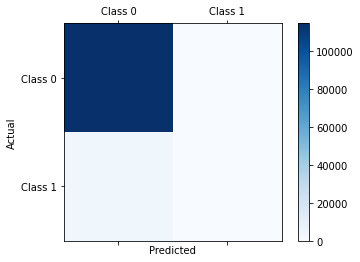

In [10]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# lets use Resampling to balance the data

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

Despite the advantage of balancing classes, these techniques also have their weaknesses (As discussed above). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.


## Simple Implentation using <code>DataFrame.sample</code> method to get random samples

In [11]:
# Class count
count_class_0, count_class_1 = df_train.target.value_counts()

# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

<h2 id="t5">Random under-sampling</h2>

Random under-sampling:
0    21694
1    21694
Name: target, dtype: int64


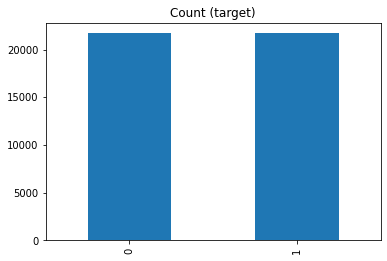

In [12]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');

<h2 id="t6">Random over-sampling</h2>

Random over-sampling:
0    573518
1    573518
Name: target, dtype: int64


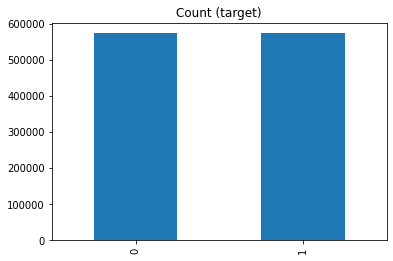

In [13]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)');

## resampling using Imblearn Module

A number of more sophisticated resapling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/). It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

In [14]:
import imblearn

For better visualization, let's work with a small unbalanced sample dataset using the <code>make_classification</code> method:

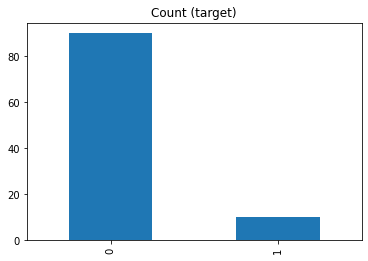

In [15]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=100, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');

We will also create a 2-dimensional plot function, <code>plot_2d_space</code>, to see the data distribution:

In [16]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

Because the dataset has many dimensions (features) and our graphs will be 2D, we will reduce the size of the dataset using Principal Component Analysis (PCA):

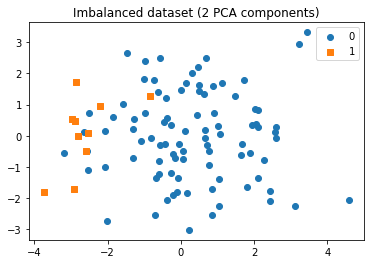

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

<h2 id="#t72">Random under-sampling and over-sampling with imbalanced-learn</h2>

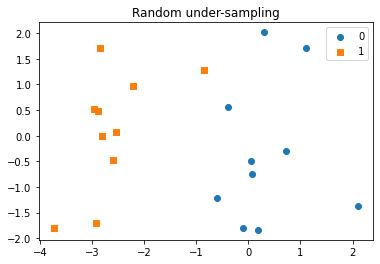

In [22]:
from imblearn.under_sampling import RandomUnderSampler

# https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
rus = RandomUnderSampler(random_state = 42)
X_rus, y_rus = rus.fit_resample(X, y)
plot_2d_space(X_rus, y_rus, 'Random under-sampling')

80 new random picked points


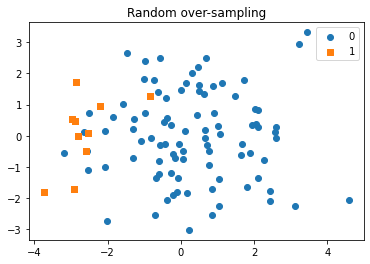

In [23]:
from imblearn.over_sampling import RandomOverSampler
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
ros = RandomOverSampler(random_state = 42)
X_ros, y_ros = ros.fit_resample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

## Under-sampling using Tomek links

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/tomek.png?v=2)

In the code below, we'll use <code>sampling_strategy='majority'</code> to resample the majority class.

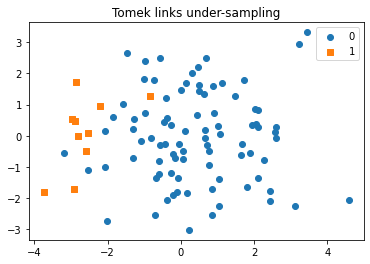

In [24]:
from imblearn.under_sampling import TomekLinks
# https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.TomekLinks.html
tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X, y)
plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

## Under-sampling using Cluster Centroids

This technique performs under-sampling by generating centroids based on clustering methods. The data will be previously grouped by similarity, in order to preserve information.


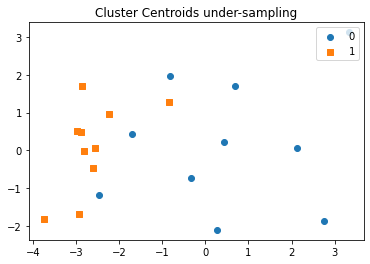

In [27]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(sampling_strategy='majority',random_state = 42)
X_cc, y_cc = cc.fit_resample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

## Over-sampling using SMOTE

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

 ![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

We'll use <code>sampling_strategy='minority'</code> to resample the minority class.

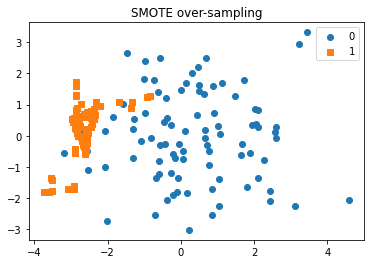

In [30]:
from imblearn.over_sampling import SMOTE
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

## lets do both Over-sampling followed by under-sampling 

Now, we will do a combination of over-sampling and under-sampling, using the SMOTE and Tomek links techniques:

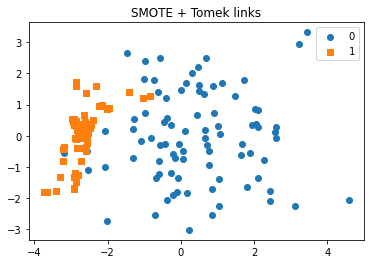

In [31]:
from imblearn.combine import SMOTETomek
# https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html
smt = SMOTETomek(sampling_strategy='auto')
X_smt, y_smt = smt.fit_resample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')